In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from pipeline_utilities_v2 import model_generator


In [2]:
# Load dataframe
df = pd.read_csv('https://archive.ics.uci.edu/static/public/329/data.csv')
df.head()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [3]:
# Explore dataframe for number of row and columns, any null values and datatypes. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quality                    1151 non-null   int64  
 1   pre_screening              1151 non-null   int64  
 2   ma1                        1151 non-null   int64  
 3   ma2                        1151 non-null   int64  
 4   ma3                        1151 non-null   int64  
 5   ma4                        1151 non-null   int64  
 6   ma5                        1151 non-null   int64  
 7   ma6                        1151 non-null   int64  
 8   exudate1                   1151 non-null   float64
 9   exudate2                   1151 non-null   float64
 10  exudate3                   1151 non-null   float64
 11  exudate3.1                 1151 non-null   float64
 12  exudate5                   1151 non-null   float64
 13  exudate6                   1151 non-null   float

In [4]:
# Determine if the target is balanced or imbalanced.
df['Class'].value_counts()

Class
1    611
0    540
Name: count, dtype: int64

The target column "Class" is balanced. 

In [5]:
# Additional Columns to get value counts for
columns_to_count = ['quality', 'pre_screening', 'am_fm_classification']

# Iterating through each specified column and printing value counts
for column in columns_to_count:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print() 

Value counts for quality:
quality
1    1147
0       4
Name: count, dtype: int64

Value counts for pre_screening:
pre_screening
1    1057
0      94
Name: count, dtype: int64

Value counts for am_fm_classification:
am_fm_classification
0    764
1    387
Name: count, dtype: int64



The dataset contains largely high quality images, most with severe retinal abnormality. 

In [6]:
# Create X & Y variables 
df = df.rename(columns={'Class': 'y'})
X = df.drop('y', axis=1)
y = df['y']

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.describe()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,0.996739,0.915217,38.221739,36.752174,35.034783,32.216304,28.698913,21.053261,63.244013,22.567026,8.529531,1.800588,0.542897,0.203199,0.080350,0.033318,0.523609,0.108714,0.327174
std,0.057042,0.278709,25.644017,24.120064,22.868857,21.230174,19.596351,15.056094,59.130185,21.899020,11.833751,3.928454,2.437831,0.993932,0.347848,0.145953,0.027919,0.018382,0.469437
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.349274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367762,0.057906,0.000000
25%,1.000000,1.000000,16.000000,15.750000,15.000000,13.000000,11.000000,8.000000,21.297663,7.667363,1.200086,0.076459,0.000000,0.000000,0.000000,0.000000,0.503333,0.095990,0.000000
50%,1.000000,1.000000,36.000000,35.000000,32.000000,29.000000,25.000000,18.000000,43.469673,16.409107,4.299345,0.468301,0.020348,0.001041,0.000000,0.000000,0.523315,0.106640,0.000000
75%,1.000000,1.000000,55.000000,53.000000,51.000000,48.000000,43.000000,32.000000,82.682002,30.002288,11.244207,1.893094,0.191907,0.036203,0.004815,0.003821,0.544085,0.120162,1.000000
max,1.000000,1.000000,151.000000,132.000000,120.000000,105.000000,97.000000,89.000000,403.939108,167.131427,106.070092,59.766121,51.423208,20.098605,3.739609,1.922177,0.592217,0.219199,1.000000


In [8]:
# def model_generator(X_test, y_test, X_train, y_train):
models = [("Logistic Regression", LogisticRegression()),
("Support Vector Machine", SVC()),
("K-Nearest Neighbors", KNeighborsClassifier()),
("Decision Tree", DecisionTreeClassifier()),
("Random Forest", RandomForestClassifier()),
("Extremely Random Trees", ExtraTreesClassifier()),
("Gradient Boosting", GradientBoostingClassifier()),
("AdaBoost", AdaBoostClassifier()),
("Naive Bayes", GaussianNB())]


In [9]:
# 
model_scores = []

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()),(name, model)])
    model_score  = pipe.fit(X_train, y_train).score(X_test, y_test)
    print(f"Fitting {name}...")
    model_scores.append((name, model_score))
    
    # Predict on the test data
    y_pred = pipe.predict(X_test)
   
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Evaluating {name}...")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    

Fitting Logistic Regression...
Evaluating Logistic Regression...
Accuracy: 0.7056
Confusion Matrix:
[[83 30]
 [38 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       113
           1       0.73      0.68      0.70       118

    accuracy                           0.71       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.71      0.71      0.71       231

Fitting Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.7013
Confusion Matrix:
[[89 24]
 [45 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       113
           1       0.75      0.62      0.68       118

    accuracy                           0.70       231
   macro avg       0.71      0.70      0.70       231
weighted avg       0.71      0.70      0.70       231

Fitting K-Nearest Neighbors...
Evaluating K-Nearest Ne

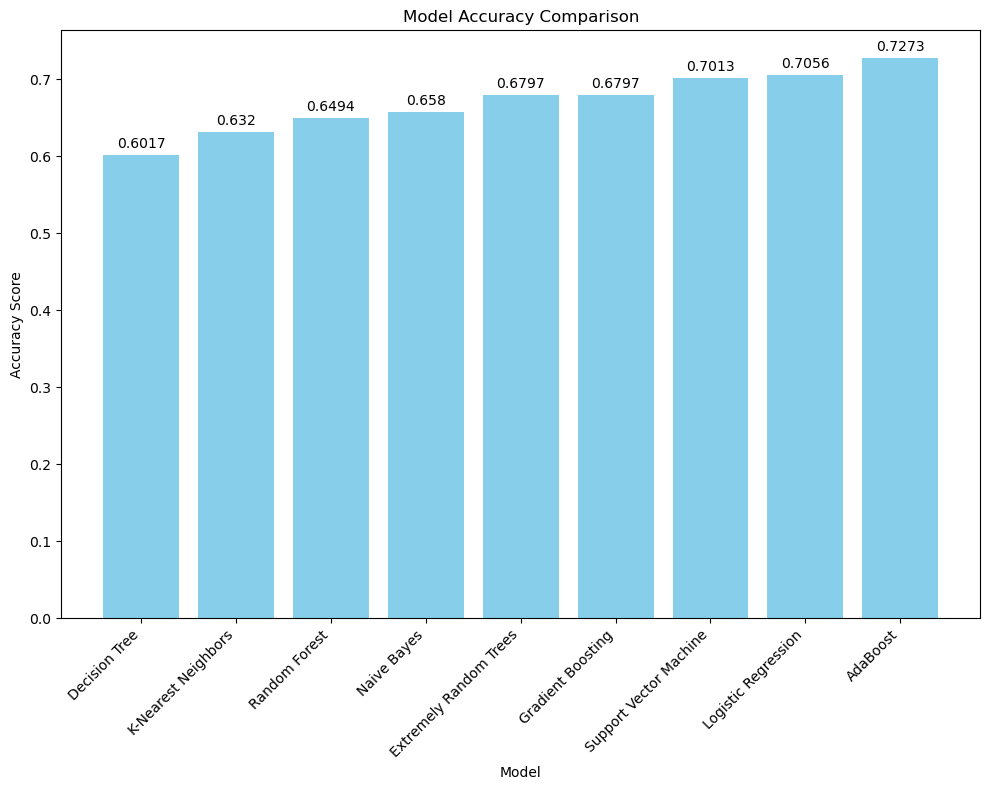

In [10]:
# Plot Model Scores for Comparison

def plot_model_scores(model_scores):
    # Sort model_scores by the score, which is the second item in each tuple
    sorted_scores = sorted(model_scores, key=lambda x: x[1])
    
    # Unpack model names and their scores into separate lists
    names, scores = zip(*sorted_scores)
    
    # Create a bar chart
    plt.figure(figsize=(10, 8))  # Set the figure size for better readability
    bars = plt.bar(names, scores, color='skyblue')  # Plot the sorted scores with model names as x-axis labels
    
    plt.xlabel('Model')  # Set x-axis label
    plt.ylabel('Accuracy Score')  # Set y-axis label
    plt.title('Model Accuracy Comparison')  # Set the title of the chart
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    
    # Add a data label on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

plot_model_scores(model_scores)

